In [1]:
from pct.tree.heuristic.Heuristic import Heuristic5
from pct.tree.heuristic.NumericHeuristicCopy1 import NumericHeuristic5
from pct.tree.splitter.splitterCopy1 import Splitter
from pct.tree.treeCopy2 import Tree

In [2]:
# import pysparnn.cluster_index as ci
# import scipy.sparse
# import os
import math
import numpy as np
import pandas as pd
import random
from utils import train_test_split, df_to_matrix ,matrix_to_df_2, threshold_interactions_df, matrix_to_df,set_intersection,get_0_and_p_index,set_diff, matrix_to_full_df


In [3]:
from surprise import Reader, accuracy
from surprise import SVD
from surprise import Dataset
from collections import Counter

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [5]:
data = pd.read_csv("C:/Users/13447/Desktop/Stats thesis/ml-1m/ml-1m/ratings.dat",sep='::',index_col=False,names=["user_id","item_id","rating","timestamp"],header=None,engine='python')
my_seed = 7
random.seed(my_seed)
np.random.seed(my_seed)
data

,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [11]:
data = threshold_interactions_df(data,'user_id','item_id',100,100)
matrix,rid_to_idx, idx_to_rid, cid_to_idx, idx_to_cid = df_to_matrix(data,"user_id","item_id","rating")

# split to train, X and eval sets
al,train,_ = train_test_split(matrix,1)

# ml 1M
X_matrix,test,_ = train_test_split(al,30)

Starting interactions info
Number of rows: 6040
Number of cols: 3706
Sparsity: 4.468%
Ending interactions info
Number of rows: 2828
Number of columns: 1919
Sparsity: 14.284%


In [12]:
train_df = matrix_to_df_2(train,idx_to_rid,idx_to_cid)
train_copy = (train.tolil()).copy()
x_df = matrix_to_full_df(train_copy, idx_to_rid, idx_to_cid)
x_df= x_df.sort_index(axis=1).sort_index(axis=0) 
x_df

,1,2,3,4,5,6,7,10,11,12,...,3918,3926,3927,3928,3930,3932,3937,3948,3949,3952
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
def i_variance(matirx):
    c = matrix.copy()
    c_2 = c.power(2)
    E_2 = c_2.mean(0)
    E = c.mean(0)
    v = E_2 - np.sqrt(E)
    return (np.asarray(v)).flatten()

def i_random(matirx):
    c = matrix.copy()
    c_2 = c.power(2)
    E_2 = c_2.mean(0)
    E = c.mean(0)
    v = E_2 - np.sqrt(E)
    return (np.asarray(v)).flatten()
    
def i_entropy(matirx):
    entropy = []
    for item in range(0, matirx.shape[1]):
        ratings = matirx.getcol(item).data
        count_r = Counter(ratings)
        len_rating = len(ratings)
        ent = 0
        for c in count_r:
            ent -= (count_r[c]/len_rating)*math.log(count_r[c]/len_rating)
        entropy.append(ent)
    return (np.asarray(entropy))

def i_entropy_0(matirx):
    entropy = []
    c_all = matirx.shape[0]
    for item in range(0, matirx.shape[1]):
        ratings = matirx.getcol(item).data
        count_r = Counter(ratings)
        count_r[0] = c_all - matirx.getcol(item).count_nonzero()
        ent = 0
        for c in count_r:
            ent -= (count_r[c]/c_all)*math.log(count_r[c]/c_all)
        entropy.append(ent)
    return (np.asarray(entropy))

def i_pop(matrix):
    popularity = []
    for item in range(0, matrix.shape[1]):
        popularity.append(matrix.getcol(item).count_nonzero())
        
    return (np.asarray(popularity))

def log_pop_entropy(matrix):
    entropy = i_entropy(matrix)
    popularity = i_pop(matrix)
    scores = np.log(popularity) *  entropy 
    return (np.asarray(scores))

def log_pop_entropy0(matrix):
    entropy = i_entropy_0(matrix)
    popularity = i_pop(matrix)
    scores = np.log(popularity) *  entropy 
    return (np.asarray(scores))

def sqrt_pop_variance(matrix):
    variance = i_variance(matrix)
    popularity = i_pop(matrix)
    scores = np.sqrt(popularity) *  variance 
    return (np.asarray(scores))

def helf(matrix):
    log_U = np.log(matrix.shape[0])
    lf = np.log(i_pop(matrix))/log_U
    h = i_entropy(matrix)/np.log(5)
    helf = (2* lf*h)/(lf+h)
    return helf

def helf0(matrix):
    log_U = np.log(matrix.shape[0])
    lf = np.log(i_pop(matrix))/log_U
    h = i_entropy_0(matrix)/np.log(5)
    helf = (2* lf*h)/(lf+h)
    return helf

def i_co_rate(matrix):
    matrix_c = matrix.copy()
    matrix_c[matrix_c != 0] = 1
    c= matrix_c.T.dot(matrix_c)
    c.setdiag(0, k=0)
    
    return np.asarray(c.sum(axis=0))[0]

In [15]:
def elicitation_np(train,test,X,strategy,iteration,k,positive=False):
    rmse,mae = [],[]
    
    # Performance before elicitation
    train_df = matrix_to_df_2(train,idx_to_rid,idx_to_cid)
    reader = Reader(rating_scale=(1, 5))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    data_rr = data_r.build_full_trainset()
    algo = SVD()
    algo.fit(data_rr)
    test_df = matrix_to_df_2(test,idx_to_rid,idx_to_cid)
    test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    test_rr = test_r.build_full_trainset()
    predictions= algo.test(test_rr.build_testset())
    rmse.append(accuracy.rmse(predictions))
    mae.append(accuracy.mae(predictions))
    
    c_u_dict = {}
    all_items = list(range(0,train.shape[1]))
    X_copy = (X.tolil()).copy()
    
    train_copy = (train.tolil()).copy()

    #scores = strategy(train_copy)
    
    for count in range(0,iteration-1):
        scores = strategy(train_copy)
        if positive:
            ranking = np.argsort(-scores)
        else:
            ranking = np.argsort(scores)
        for u in range(0, train.shape[0]):
            if count ==0:
                p_u = train_copy.getrow(u).nonzero()[1]
                c_u = set_diff(all_items,p_u)
                c_u_dict[u] = c_u.copy()
            else:
                c_u = c_u_dict[u].copy()                
          
            ranking_u = ranking[np.in1d(ranking,c_u)]
            topk_u = ranking_u[:k]
            c_u_dict[u] = set_diff(c_u,topk_u)
            px_u = X_copy.getrow(u).nonzero()[1]
            recom = set_intersection(topk_u,px_u)
            for item in recom:                  
                train_copy[u,item] = X[u,item]
                X_copy[u,item] = 0
        train_df = matrix_to_df_2(train_copy,idx_to_rid,idx_to_cid)

        reader = Reader(rating_scale=(1, 5))
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        data_rr = data_r.build_full_trainset()
        algo.fit(data_rr)
        test_df = matrix_to_df(test,idx_to_rid,idx_to_cid)
        test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        test_rr = test_r.build_full_trainset()
        predictions= algo.test(test_rr.build_testset())
        rmse.append(accuracy.rmse(predictions))
        mae.append(accuracy.mae(predictions))
        
        print(count+1)
    return rmse,mae

In [17]:
def elicitation_by_tree_path(tree_model, train, test, X, idx_to_rid, idx_to_cid, iteration=5):
    """
    Elicitation using a trained PCT tree. Each user is asked one item per tree level
    based on their path down the tree. Only one tree fit is performed.

    Parameters:
    - tree_model: untrained PCT Tree model instance
    - train: sparse lil_matrix, initial known ratings
    - test: sparse lil_matrix, test ratings
    - X: full ground truth rating matrix (lil_matrix)
    - idx_to_rid, idx_to_cid: dicts mapping matrix indices to raw user/item IDs
    - iteration: number of elicitation rounds (usually tree depth + 1)

    Returns:
    - rmse_list: list of RMSE scores per iteration (including initial baseline)
    - mae_list: list of MAE scores per iteration (including initial baseline)
    """
   
    num_users, num_items = train.shape
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    user_paths = {u: None for u in range(num_users)}  # will be initialized after tree fit

    rmse_list, mae_list = [], []

    # Step 1: Evaluate SVD baseline before elicitation
    train_df = matrix_to_df_2(train_copy, idx_to_rid, idx_to_cid)
    reader = Reader(rating_scale=(1, 5))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    trainset = data_r.build_full_trainset()
    algo = SVD()
    algo.fit(trainset)

    test_df = matrix_to_df_2(test, idx_to_rid, idx_to_cid)
    test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    testset = test_data.build_full_trainset().build_testset()
    predictions = algo.test(testset)
    rmse_list.append(accuracy.rmse(predictions, verbose=True))
    mae_list.append(accuracy.mae(predictions, verbose=True))
    print("✅ Baseline performance computed.")

    # Step 2: Fit the tree using dense DataFrame from train_copy
    x_df = matrix_to_full_df(train_copy, idx_to_rid, idx_to_cid)
    tree_model.fit(x_df, x_df)
    print("🌳 Tree training complete.")
    cid_to_idx = {v: k for k, v in idx_to_cid.items()}
    
    # Step 3: Initialize user positions at root
    for u in range(num_users):
        user_paths[u] = tree_model.root

    # Step 4: Iterative elicitation
    for i in range(iteration):
        for u in range(num_users):
            node = user_paths[u]
            if node is None or node.is_leaf or node.attribute_name is None:
                continue  # No further questions for this user
            item = node.attribute_name
            if item not in cid_to_idx:
                continue  # skip if item not in matrix
            item_index = cid_to_idx[item]
            
            rating = X_copy[u, item_index]
            if rating > 0:
                train_copy[u, item_index] = rating
                X_copy[u, item_index] = 0  # Prevent reuse

            if rating == 0:
                user_paths[u] = node.children[2]  # Unknowns
            elif rating >= 4:
                user_paths[u] = node.children[0]  # Lovers
            else:
                user_paths[u] = node.children[1]  # Haters

        # Evaluate after this round
        train_df = matrix_to_df_2(train_copy, idx_to_rid, idx_to_cid)
        reader = Reader(rating_scale=(1, 5))
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        trainset = data_r.build_full_trainset()
        algo = SVD()
        algo.fit(trainset)

        test_df = matrix_to_df_2(test, idx_to_rid, idx_to_cid)
        test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        testset = test_data.build_full_trainset().build_testset()
        predictions = algo.test(testset)

        rmse_list.append(accuracy.rmse(predictions, verbose=True))
        mae_list.append(accuracy.mae(predictions, verbose=True))
        print(f"✅ Iteration {i+1}/{iteration} complete.")

    return rmse_list, mae_list


In [25]:
def elicitation_by_tree_path_retrain_depth(tree_model_class, train, test, X, idx_to_rid, idx_to_cid, iteration=5):
    """
    Method 2 (final): Retrain tree each round, walk i steps based on train_copy ratings.
    Follow tree splits using 3-way logic (Lovers / Haters / Unknown).
    Ask the item at depth i if user reaches it.

    Parameters:
    - tree_model_class: class (not instance) of the tree model
    - train, test, X: lil_matrix
    - idx_to_rid, idx_to_cid: mapping of matrix index to raw ID
    - iteration: number of rounds

    Returns:
    - rmse_list, mae_list
    """
   
    num_users, num_items = train.shape
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    rmse_list, mae_list = [], []
    cid_to_idx = {v: k for k, v in idx_to_cid.items()}

    # Step 0: Baseline SVD
    train_df = matrix_to_df_2(train_copy, idx_to_rid, idx_to_cid)
    reader = Reader(rating_scale=(1, 5))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    trainset = data_r.build_full_trainset()
    algo = SVD()
    algo.fit(trainset)
    test_df = matrix_to_df_2(test, idx_to_rid, idx_to_cid)
    test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    testset = test_data.build_full_trainset().build_testset()
    predictions = algo.test(testset)
    rmse_list.append(accuracy.rmse(predictions, verbose=True))
    mae_list.append(accuracy.mae(predictions, verbose=True))
    print("✅ Baseline evaluation complete.")

    for i in range(iteration):
        print(f"\n🔁 Iteration {i+1}/{iteration} (walk to depth {i})")

        # Retrain new tree based on updated K
        tree_model = tree_model_class()
        x_df = matrix_to_full_df(train_copy, idx_to_rid, idx_to_cid)
        tree_model.fit(x_df, x_df)
        print("🌳 Tree re-trained.")

        for u in range(num_users):
            node = tree_model.root
            depth = 0

            # Walk i steps using user rating in train_copy
            while node and not node.is_leaf and node.attribute_name and depth < i:
                item = node.attribute_name
                if item not in cid_to_idx:
                    node = None
                    break
                item_idx = cid_to_idx[item]
                rating = train_copy[u, item_idx]

                if rating >= 4:
                    node = node.children[0]  # Lovers
                elif rating > 0:
                    node = node.children[1]  # Haters
                else:
                    node = node.children[2]  # Unknowns 

                depth += 1

            # Ask item at depth i
            if node is None or node.is_leaf or node.attribute_name is None:
                continue

            item = node.attribute_name
            if item not in cid_to_idx:
                continue
            item_idx = cid_to_idx[item]
            rating = X_copy[u, item_idx]

            if rating > 0:
                train_copy[u, item_idx] = rating
                X_copy[u, item_idx] = 0
                

        # Evaluate after each round
        train_df = matrix_to_df_2(train_copy, idx_to_rid, idx_to_cid)
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        trainset = data_r.build_full_trainset()
        algo.fit(trainset)
        test_df = matrix_to_df_2(test, idx_to_rid, idx_to_cid)
        test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        testset = test_data.build_full_trainset().build_testset()
        predictions = algo.test(testset)
        rmse_list.append(accuracy.rmse(predictions, verbose=True))
        mae_list.append(accuracy.mae(predictions, verbose=True))
        print(f"✅ Iteration {i+1} complete.")

    return rmse_list, mae_list




In [31]:
def elicitation_by_tree_path_retrain_skip(tree_model_class, train, test, X, idx_to_rid, idx_to_cid, iteration=5):
    """
    Method 3: Retrain tree at each round. For each user, traverse from root down the tree.
    At each level, if the item was already asked (i.e., exists in train_copy), go one level deeper.
    Ask the first item the user hasn't been asked before.

    Parameters:
    - tree_model_class: class of the decision tree model (not instance)
    - train, test, X: lil_matrix (known ratings, test set, and full matrix)
    - idx_to_rid, idx_to_cid: index-to-ID mapping
    - iteration: number of elicitation rounds

    Returns:
    - rmse_list, mae_list
    """
   

    num_users, num_items = train.shape
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    rmse_list, mae_list = [], []
    cid_to_idx = {v: k for k, v in idx_to_cid.items()}

    # Step 0: Baseline evaluation
    train_df = matrix_to_df_2(train_copy, idx_to_rid, idx_to_cid)
    reader = Reader(rating_scale=(1, 5))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    trainset = data_r.build_full_trainset()
    algo = SVD()
    algo.fit(trainset)
    test_df = matrix_to_df_2(test, idx_to_rid, idx_to_cid)
    test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    testset = test_data.build_full_trainset().build_testset()
    predictions = algo.test(testset)
    rmse_list.append(accuracy.rmse(predictions, verbose=True))
    mae_list.append(accuracy.mae(predictions, verbose=True))
    print("✅ Baseline evaluation complete.")

    for i in range(iteration):
        print(f"\n🔁 Iteration {i+1}/{iteration} (skip asked items, walk from root)")

        # Retrain tree using current train_copy
        tree_model = tree_model_class()
        x_df = matrix_to_full_df(train_copy, idx_to_rid, idx_to_cid)
        tree_model.fit(x_df, x_df)
        print("🌳 Tree re-trained.")

        for u in range(num_users):
            node = tree_model.root

            # Traverse down the tree until we find an unasked item
            while node and not node.is_leaf and node.attribute_name:
                item = node.attribute_name
                if item not in cid_to_idx:
                    node = None
                    break

                item_idx = cid_to_idx[item]
                rating = train_copy[u, item_idx]

                if rating > 0:
                    # Already asked, go deeper using original rating to determine path
                    if rating >= 4:
                        node = node.children[0]
                    elif rating > 0:
                        node = node.children[1]
                    else:
                        node = node.children[2]
                    continue
                else:
                    # Not asked yet, this is the item to ask
                    rating = X_copy[u, item_idx]
                    if rating > 0:
                        train_copy[u, item_idx] = rating
                        X_copy[u, item_idx] = 0
                    break  # Only ask one item per user

        # Step 3: Evaluate with SVD
        train_df = matrix_to_df_2(train_copy, idx_to_rid, idx_to_cid)
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        trainset = data_r.build_full_trainset()
        algo.fit(trainset)
        test_df = matrix_to_df_2(test, idx_to_rid, idx_to_cid)
        test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        testset = test_data.build_full_trainset().build_testset()
        predictions = algo.test(testset)
        rmse_list.append(accuracy.rmse(predictions, verbose=True))
        mae_list.append(accuracy.mae(predictions, verbose=True))
        print(f"✅ Iteration {i+1} complete.")

    return rmse_list, mae_list


In [21]:
def elicitation_p(train, test, X, tree_model, iteration, k, idx_to_rid, idx_to_cid):
    rmse, mae = [], []

    # Initial evaluation of the SVD recommender
    train_df = matrix_to_df_2(train, idx_to_rid, idx_to_cid)
    reader = Reader(rating_scale=(1, 5))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    data_rr = data_r.build_full_trainset()
    algo = SVD()
    algo.fit(data_rr)

    test_df = matrix_to_df_2(test, idx_to_rid, idx_to_cid)
    test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    test_rr = test_r.build_full_trainset()
    predictions = algo.test(test_rr.build_testset())
    rmse.append(accuracy.rmse(predictions))
    mae.append(accuracy.mae(predictions))

    # Initialization
    c_u_dict = {}
    all_items = list(range(0, train.shape[1]))
    X_matrix = (X.tolil()).copy()
    train_copy = (train.tolil()).copy()

    for count in range(iteration - 1):
        # Step 1: Convert to DataFrame and train the tree
        x_df = matrix_to_full_df(train_copy, idx_to_rid, idx_to_cid)
        tree_model.fit(x_df, x_df)

        # Step 2: Use the tree to predict ratings for unrated items
        pred_df = tree_model.predict_test(x_df)  # Same structure as x_df, values are predicted scores

        for u in range(train.shape[0]):
            if count == 0:
                p_u = train_copy.getrow(u).nonzero()[1]
                c_u = set_diff(all_items, p_u)
                c_u_dict[u] = c_u.copy()
            else:
                c_u = c_u_dict[u].copy()

            # Rank the predictions and select top-k
            pred_u = pred_df.iloc[u].to_dict()
            pred_dict = {i: pred_u[idx_to_cid[i]] for i in c_u}
            ranking_u = sorted(pred_dict.items(), key=lambda x: -x[1])
            topk_u = [item for item, _ in ranking_u[:k]]
            c_u_dict[u] = set_diff(c_u, topk_u)

            # Add items that the user has actually rated into train_copy
            px_u = X_matrix.getrow(u).nonzero()[1]
            recom = [item for item in topk_u if item in px_u]
            for item in recom:
                train_copy[u, item] = X[u, item]
                X_matrix[u, item] = 0

        # Step 3: Retrain SVD and record RMSE
        train_df = matrix_to_df_2(train_copy, idx_to_rid, idx_to_cid)
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        data_rr = data_r.build_full_trainset()
        algo.fit(data_rr)

        test_df = matrix_to_df_2(test, idx_to_rid, idx_to_cid)
        test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        test_rr = test_r.build_full_trainset()
        predictions = algo.test(test_rr.build_testset())
        rmse.append(accuracy.rmse(predictions))
        mae.append(accuracy.mae(predictions))

        print(f"Iteration {count+1} done.")

    return rmse, mae


In [33]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


tree = Tree(max_depth=7)
pct_3 = elicitation_by_tree_path_retrain_skip(Tree, train, test, X_matrix, idx_to_rid, idx_to_cid, iteration=8)

RMSE: 1.1630
MAE:  0.9687
✅ Baseline evaluation complete.

🔁 Iteration 1/8 (skip asked items, walk from root)
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 1.0998
MAE:  0.9174
✅ Iteration 1 complete.

🔁 Iteration 2/8 (skip asked items, walk from root)
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 1.0963
MAE:  0.9145
✅ Iteration 2 complete.

🔁 Iteration 3/8 (skip asked items, walk from root)
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 1.0911
MAE:  0.9099
✅ Iteration 3 complete.

🔁 Iteration 4/8 (skip asked items, walk from root)
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 1.0922
MAE:  0.9113
✅ Iteration 4 complete.

🔁 Iteration 5/8 (skip asked items, walk from root)
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 1.0908
MAE:  0.9097
✅ Iteration 5 complete.

🔁 Iteration 6/8 (skip asked items, walk from root)
Initializing Splitter...


In [27]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


tree = Tree(max_depth=7)
pct_2 = elicitation_by_tree_path_retrain_depth(Tree, train, test, X_matrix, idx_to_rid, idx_to_cid, iteration=8)

RMSE: 1.1624
MAE:  0.9678
✅ Baseline evaluation complete.

🔁 Iteration 1/8 (walk to depth 0)
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 1.1004
MAE:  0.9178
✅ Iteration 1 complete.

🔁 Iteration 2/8 (walk to depth 1)
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 1.0808
MAE:  0.9009
✅ Iteration 2 complete.

🔁 Iteration 3/8 (walk to depth 2)
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 1.0676
MAE:  0.8866
✅ Iteration 3 complete.

🔁 Iteration 4/8 (walk to depth 3)
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 1.0676
MAE:  0.8867
✅ Iteration 4 complete.

🔁 Iteration 5/8 (walk to depth 4)
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 1.0663
MAE:  0.8855
✅ Iteration 5 complete.

🔁 Iteration 6/8 (walk to depth 5)
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 1.0671
MAE:  0.8862
✅ Iteration 6 complete.

🔁 Ite

In [39]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

tree = Tree(max_depth=7)
pct_1 = elicitation_by_tree_path(tree, train, test,X_matrix, idx_to_rid, idx_to_cid, iteration=8)


RMSE: 1.1624
MAE:  0.9679
✅ Baseline performance computed.
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree training complete.
RMSE: 1.1007
MAE:  0.9184
✅ Iteration 1/8 complete.
RMSE: 1.0851
MAE:  0.9053
✅ Iteration 2/8 complete.
RMSE: 1.0732
MAE:  0.8934
✅ Iteration 3/8 complete.
RMSE: 1.0694
MAE:  0.8896
✅ Iteration 4/8 complete.
RMSE: 1.0686
MAE:  0.8883
✅ Iteration 5/8 complete.
RMSE: 1.0683
MAE:  0.8880
✅ Iteration 6/8 complete.
RMSE: 1.0673
MAE:  0.8865
✅ Iteration 7/8 complete.
RMSE: 1.0671
MAE:  0.8858
✅ Iteration 8/8 complete.


In [35]:
entropy_1 = elicitation_np(train,test,X_matrix,i_entropy,iteration=10,k=1,positive=True)

RMSE: 1.1628
MAE:  0.9682
RMSE: 1.1014
MAE:  0.9179
1
RMSE: 1.0883
MAE:  0.9076
2
RMSE: 1.0771
MAE:  0.8971
3
RMSE: 1.0741
MAE:  0.8940
4
RMSE: 1.0697
MAE:  0.8886
5
RMSE: 1.0665
MAE:  0.8853
6
RMSE: 1.0600
MAE:  0.8770
7
RMSE: 1.0527
MAE:  0.8641
8
RMSE: 1.0514
MAE:  0.8610
9


In [41]:
rand_1 = elicitation_np(train,test,X_matrix,i_random,iteration=10,k=1,positive=True)

RMSE: 1.1618
MAE:  0.9675
RMSE: 1.0653
MAE:  0.8822
1
RMSE: 1.0644
MAE:  0.8557
2
RMSE: 1.0757
MAE:  0.8460
3
RMSE: 1.0904
MAE:  0.8439
4
RMSE: 1.0995
MAE:  0.8473
5
RMSE: 1.1083
MAE:  0.8512
6
RMSE: 1.1159
MAE:  0.8556
7
RMSE: 1.1204
MAE:  0.8586
8
RMSE: 1.1302
MAE:  0.8658
9


In [49]:
entropy = elicitation_np(train,test,X_matrix,i_entropy_0,iteration=10,k=20,positive=True)

RMSE: 1.1627
MAE:  0.9682
RMSE: 1.0746
MAE:  0.8343
1
RMSE: 1.0697
MAE:  0.8309
2
RMSE: 1.0597
MAE:  0.8247
3
RMSE: 1.0590
MAE:  0.8226
4
RMSE: 1.0534
MAE:  0.8189
5
RMSE: 1.0517
MAE:  0.8171
6
RMSE: 1.0493
MAE:  0.8140
7
RMSE: 1.0406
MAE:  0.8089
8
RMSE: 1.0347
MAE:  0.8046
9


In [21]:
rand = elicitation_np(train,test,X_matrix,i_random,iteration=10,k=20,positive=True)

RMSE: 1.1616
MAE:  0.9674
RMSE: 1.1455
MAE:  0.8778
1
RMSE: 1.1283
MAE:  0.8658
2
RMSE: 1.1148
MAE:  0.8562
3
RMSE: 1.1032
MAE:  0.8473
4
RMSE: 1.0947
MAE:  0.8406
5
RMSE: 1.0865
MAE:  0.8339
6
RMSE: 1.0747
MAE:  0.8252
7
RMSE: 1.0674
MAE:  0.8197
8
RMSE: 1.0629
MAE:  0.8163
9


In [23]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

tree = Tree(max_depth=7)
pct = elicitation_p(train, test, X_matrix, tree, iteration=10, k=20,
                          idx_to_rid=idx_to_rid, idx_to_cid=idx_to_cid)

RMSE: 1.1616
MAE:  0.9670
Initializing Splitter...
✅ Tree built successfully!
RMSE: 1.0477
MAE:  0.8454
Iteration 1 done.
Initializing Splitter...
✅ Tree built successfully!
RMSE: 1.0391
MAE:  0.8328
Iteration 2 done.
Initializing Splitter...
✅ Tree built successfully!
RMSE: 1.0433
MAE:  0.8234
Iteration 3 done.
Initializing Splitter...
✅ Tree built successfully!
RMSE: 1.0428
MAE:  0.8190
Iteration 4 done.
Initializing Splitter...
✅ Tree built successfully!
RMSE: 1.0405
MAE:  0.8164
Iteration 5 done.
Initializing Splitter...
✅ Tree built successfully!
RMSE: 1.0373
MAE:  0.8142
Iteration 6 done.
Initializing Splitter...
✅ Tree built successfully!
RMSE: 1.0340
MAE:  0.8110
Iteration 7 done.
Initializing Splitter...
✅ Tree built successfully!
RMSE: 1.0355
MAE:  0.8108
Iteration 8 done.
Initializing Splitter...
✅ Tree built successfully!
RMSE: 1.0314
MAE:  0.8076
Iteration 9 done.


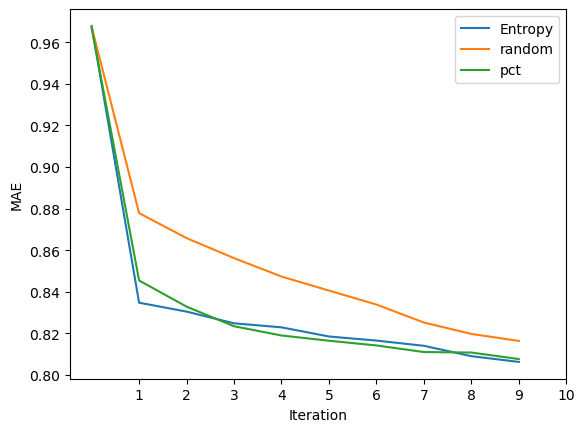

In [25]:
x = np.arange(10) 
fig, (ax1) = plt.subplots(1)
# fig.suptitle('Horizontally stacked subplots')
ax1.plot(x, entropy[1], label='Entropy')
ax1.plot(x, rand[1], label='random')
ax1.plot(x, pct[1], label='pct')

plt.legend(loc=1)
plt.xlabel("Iteration")
plt.ylabel("MAE")
plt.xticks(range(1, 11)) 
plt.show()

# plt.xticks(x, list_i)

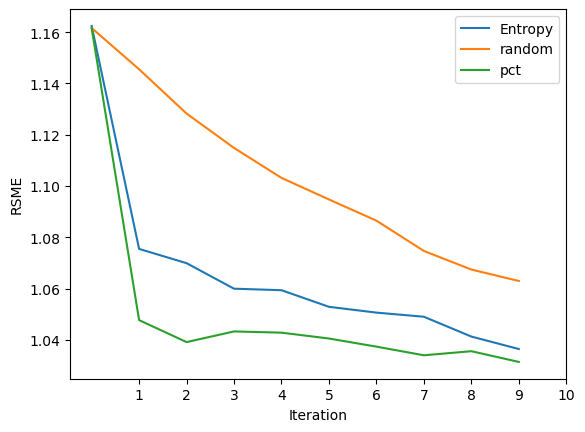

In [27]:
x = np.arange(10) 
fig, (ax1) = plt.subplots(1)
# fig.suptitle('Horizontally stacked subplots')
ax1.plot(x, entropy[0], label='Entropy')
ax1.plot(x, rand[0], label='random')
ax1.plot(x, pct[0], label='pct')

plt.legend(loc=1)
plt.xlabel("Iteration")
plt.ylabel("RSME")
plt.xticks(range(1, 11)) 
plt.show()

# plt.xticks(x, list_i)